# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Citations

Dataset: This tech report (Chapter 3) describes the dataset and the methodology followed when collecting it in much greater detail. Please cite it if you intend to use this dataset.
[Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

[Normalization values for transforms:](https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data)

[Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) - was referred by a very nice technical mentor I reached out to after going crazy all weekend with a feed-forward model that would not learn! :)



## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# My additional imports and magics & stuff
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from torchvision import datasets, models, transforms
import time
import os
import copy
from collections import OrderedDict

plt.ion()   # interactive mode

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [36]:
# Define transforms:
# 
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])


# Directories for files:
data_dir_train = '/Users/lauran_kio/Documents/Courses/Exercises/CIFAR10-Classifier/train'
data_dir_test = '/Users/lauran_kio/Documents/Courses/Exercises/CIFAR10-Classifier/test'

batch_size = 250

# Create training set and define training dataloader
trainset = datasets.CIFAR10(data_dir_train, download=True, train=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
testset = datasets.CIFAR10(data_dir_test, download=True, train=False, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [52]:
#Make sure the tensor looks as expected!
images, labels = next(iter(trainloader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([250, 3, 32, 32])
torch.Size([250])


Visualize a batch (different approach)

In [53]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [54]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 20, number of channels: 3, pixel sizes: 32x32)


(250, 3, 32, 32)

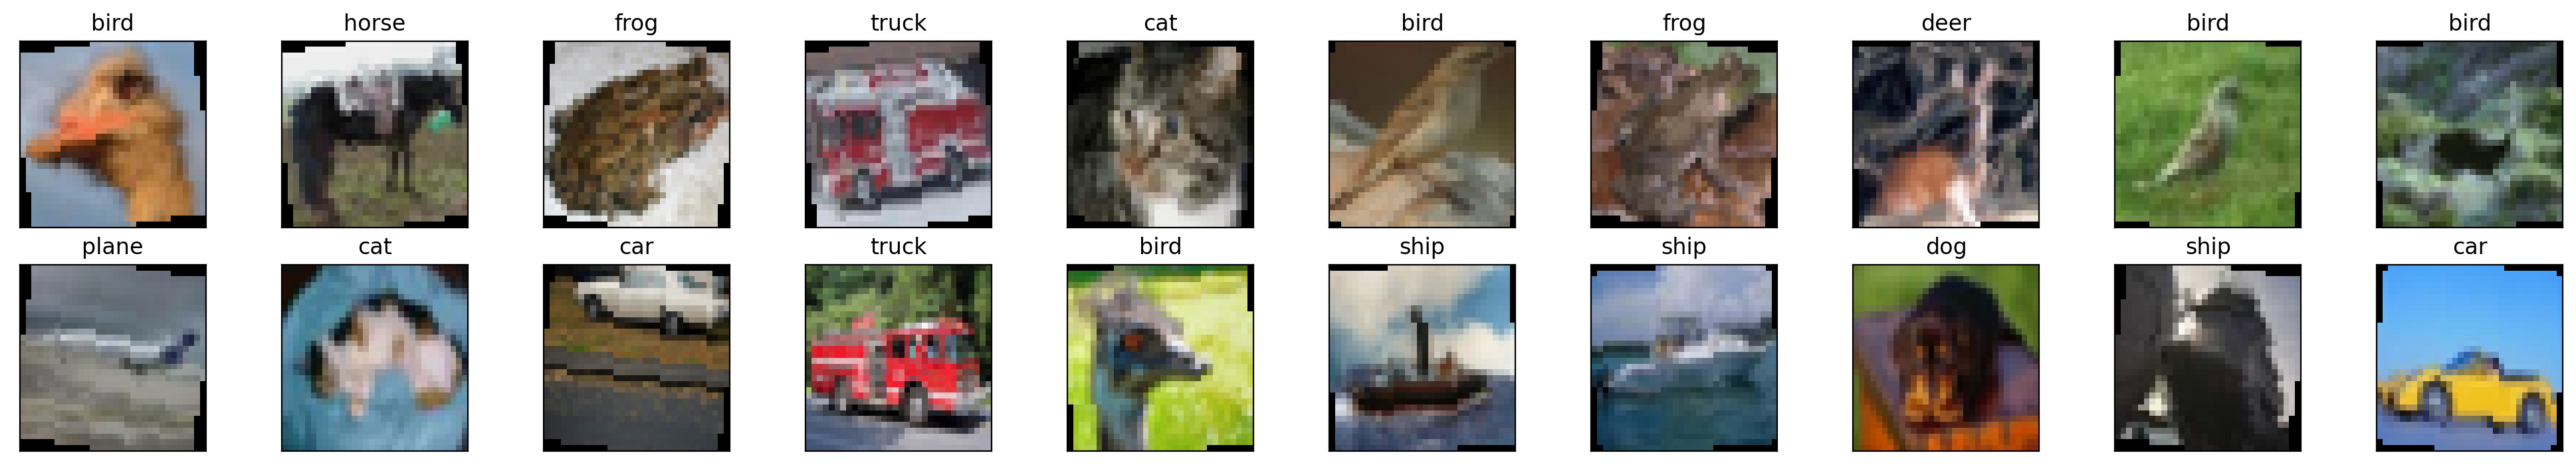

In [55]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [8]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = (images[i].numpy())/ 2 + 0.5 #undo the normalization
        plt.imshow(image.T)
        plt.show()

In [41]:
# Explore data
#show5(trainloader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

Since my DIY network failed so miserably, this time I'm going to try a pre-trained real model.

To define a model for training we'll follow these steps:

    Load in a pre-trained VGG16 model
    "Freeze" all the parameters, so the net acts as a fixed feature extractor
    Remove the last layer
    Replace the last layer with a linear classifier of our own

Freezing simply means that the parameters in the pre-trained model will not change during training.

In [56]:
# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features)

4096
1000


In [58]:
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False

In [60]:
import torch.nn as nn
vgg16 = model

n_inputs = vgg16.classifier[6].in_features
print(n_inputs)

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

4096
10


In [61]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

Recall from the lecture that densenet is a 2-part model: features and classifier. The classifier is a single fully-connected layer but it outputs 1000 features, which won't work here - we only have 10 possible outcomes. So we'll use densenet's feature part but replace the classifier layer with something custom.

# Make a custom classifier whose output is 
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(64 * 4 * 4, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(trainloader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

In [ ]:
## YOUR CODE HERE ##
# Remember!! Only do training for the classifier part of the model!!

# Use GPU if it's available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not train_on_gpu:
    print('CUDA is not available. Training on CPU.')
else:
        print('CUDA is available! Training on GPU.')
        
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU if CUDA is available
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # start timer:
        start = time.time()
        # clear the gradients of variables already optimized
        optimizer.zero_grad()
        # do fwd pass:
        outputs = vgg16(inputs)
        # Calculate loss:
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
    else:

        train_losses, test_losses = [], []

        ## TODO: Implement the validation pass and print out the validation accuracy
        ## For each training pass, you do a validation pass!!
        
        #Track the test loss and accuracy over the 10 classes:
        test_loss = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        accuracy = 0
        
        #set model to eval mode:
        vgg16.eval()
        # iterate over test data
        for data, target in testloader:
        # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## Turn off gradients - only needed for training
            with torch.no_grad():
            # Do fwd pass:
            output = vgg16(data)
            # Calculate loss:
            loss = criterion(output, target)
            # update  test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(batch_size):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        # Calculate the accuracy by taking the mean of our new equals tensor - after floatifying it
        accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        # set model back to train mode
        model.train()
        
        # Update the train_losses and test_losses lists:
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, n_epochs),
             "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
             "Test Loss: {:.3f}.. ".format(test_loss/len(trainloader)),
             "Test Accuracy:  {:.3f}.. ".format(accuracy/len(trainloader)))
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [26]:
## YOUR CODE HERE ##

train_losses, test_losses = [], []

    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        ## For each training pass, you do a validation pass!!
        
        #Track the test loss and accuracy over the 10 classes:
        test_loss = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        accuracy = 0
        
        #set model to eval mode:
        vgg16.eval()
        # iterate over test data
        for data, target in testloader:
        # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## Turn off gradients - only needed for training
            with torch.no_grad():
            # Do fwd pass:
            output = vgg16(data)
            # Calculate loss:
            loss = criterion(output, target)
            # update  test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(batch_size):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        # Calculate the accuracy by taking the mean of our new equals tensor - after floatifying it
        accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        # set model back to train mode
        model.train()
        
        # Update the train_losses and test_losses lists:
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, n_epochs),
             "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
             "Test Loss: {:.3f}.. ".format(test_loss/len(trainloader)),
             "Test Accuracy:  {:.3f}.. ".format(accuracy/len(trainloader)))

Epoch: 1/20..  Training Loss: 1.633..  Test Loss: 0.313..  Test Accuracy:  0.096.. 


KeyboardInterrupt: 

Plot the training loss (and validation loss/accuracy, if recorded).

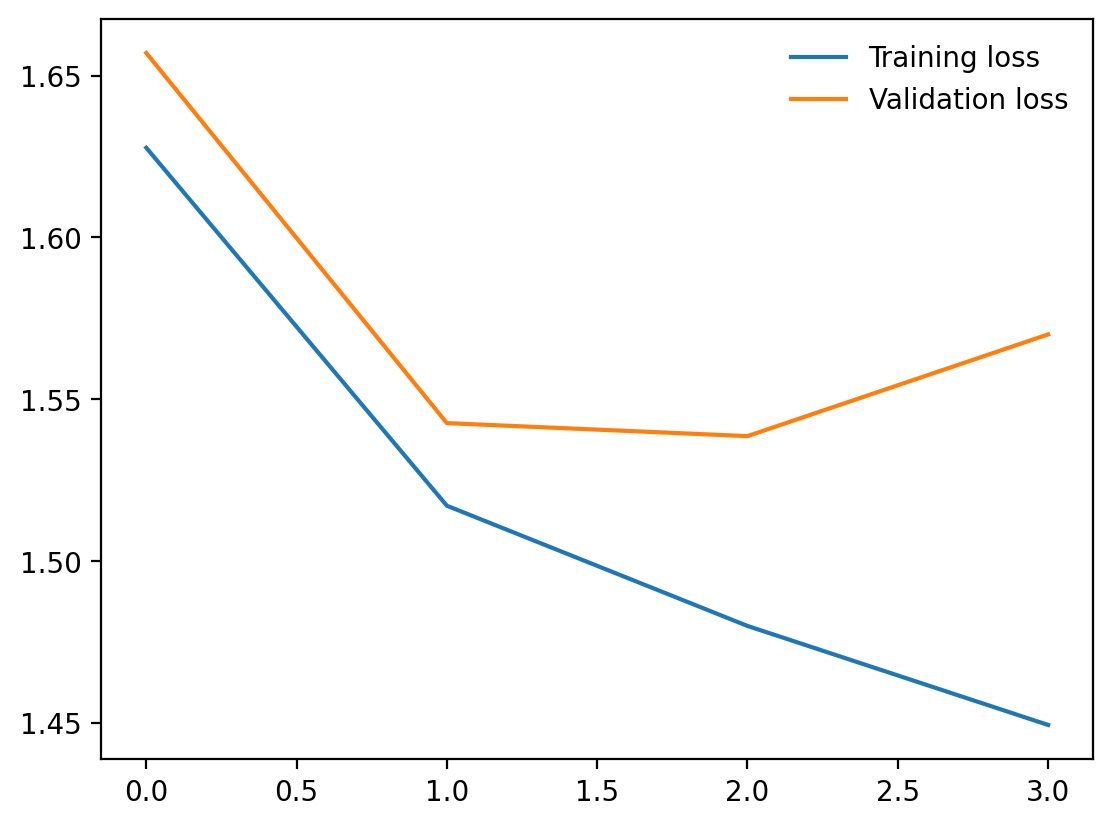

In [18]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

